In [157]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [158]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [215]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # Find contours
    kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
    image_horizontal_derivative = np.abs(image_horizontal_derivative)
    kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
    image_vertical_derivative = np.abs(image_vertical_derivative)

    image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    ret2,thresh = cv2.threshold(image_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    closed0 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    opened = cv2.morphologyEx(closed0, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
    opened1 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = np.zeros((11,11),np.uint8)
    kernel[5,:] = 1
    dilated = cv2.dilate(opened1, kernel, iterations = 5)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 405.  261.]
 [1300.  257.]
 [ 408. 1054.]
 [1304. 1051.]]
Wall time: 299 ms


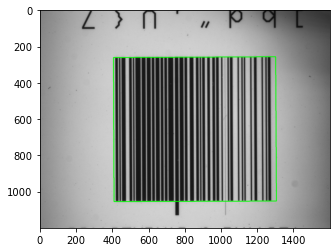

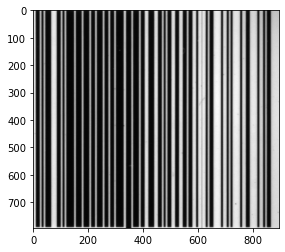

In [160]:
%%time
bound_box(f'../images/{images_paths[0]}')

[[ 353.  288.]
 [1253.  288.]
 [ 353. 1085.]
 [1253. 1085.]]
Wall time: 293 ms


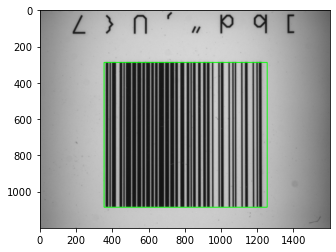

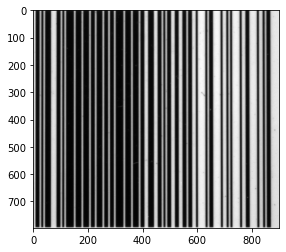

In [161]:
%%time
bound_box(f'../images/{images_paths[1]}')

[[ 202.  242.]
 [1048.  237.]
 [ 205.  725.]
 [1051.  720.]]
Wall time: 232 ms


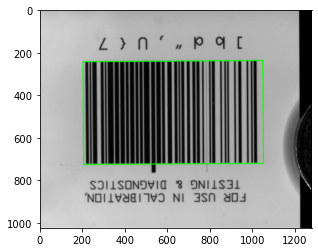

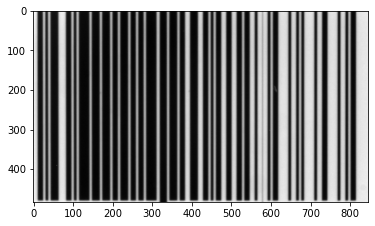

In [162]:
%%time
bound_box(f'../images/{images_paths[2]}')

[[132. 258.]
 [978. 258.]
 [132. 741.]
 [978. 741.]]
Wall time: 222 ms


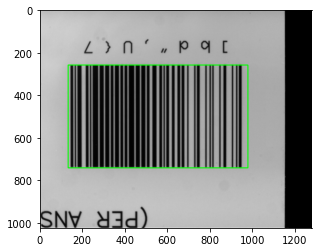

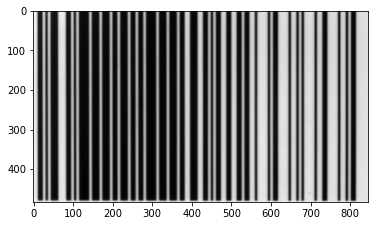

In [163]:
%%time
bound_box(f'../images/{images_paths[3]}')

[[330. 172.]
 [910. 172.]
 [330. 686.]
 [910. 686.]]
Wall time: 212 ms


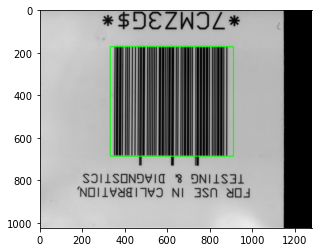

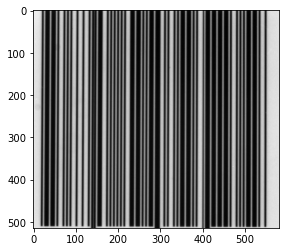

In [164]:
%%time
bound_box(f'../images/{images_paths[4]}')

[[335. 251.]
 [918. 251.]
 [335. 764.]
 [918. 764.]]


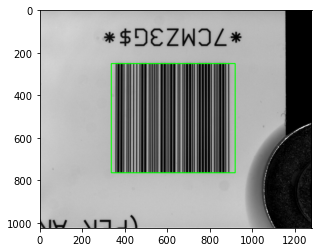

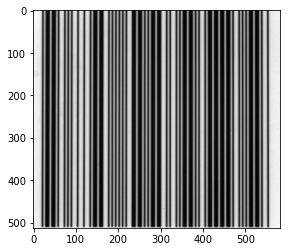

In [165]:
bound_box(f'../images/{images_paths[5]}')

[[ 162.  287.]
 [1109.  287.]
 [ 162.  801.]
 [1109.  801.]]


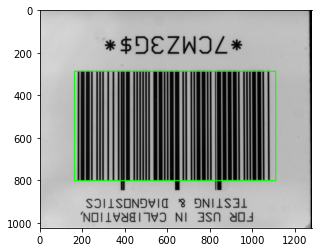

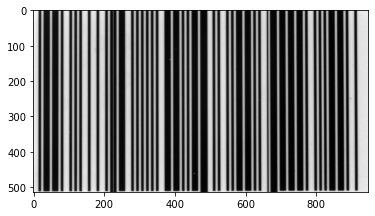

In [166]:
bound_box(f'../images/{images_paths[6]}')

[[ 147.  274.]
 [1099.  276.]
 [ 146.  789.]
 [1098.  790.]]


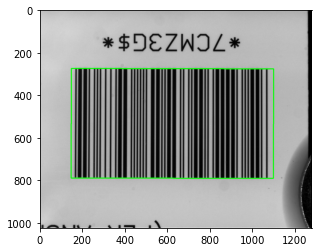

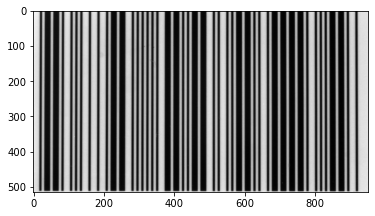

In [167]:
bound_box(f'../images/{images_paths[7]}')

[[327. 335.]
 [981. 339.]
 [324. 780.]
 [978. 784.]]


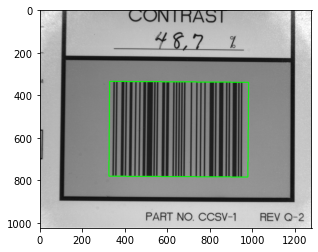

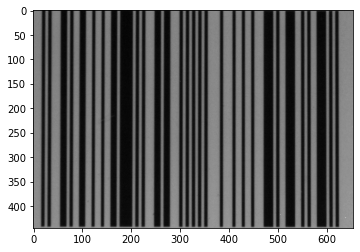

In [168]:
bound_box(f'../images/{images_paths[8]}')

[[338. 279.]
 [987. 286.]
 [333. 720.]
 [982. 728.]]


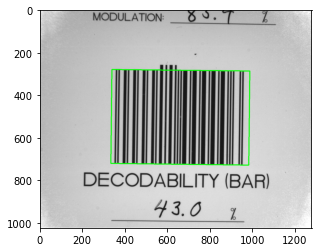

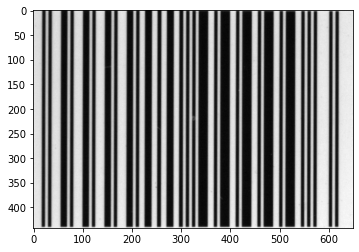

In [169]:
bound_box(f'../images/{images_paths[9]}')

In [170]:
print(f'../images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [171]:
#bound_box(f'../images/{images_paths[10]}')

[[264. 314.]
 [964. 314.]
 [264. 756.]
 [964. 756.]]


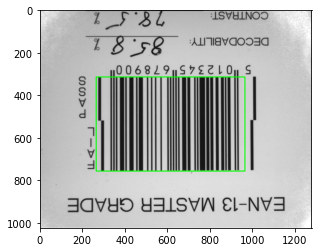

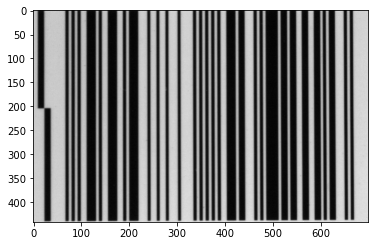

In [172]:
bound_box(f'../images/{images_paths[11]}')

In [173]:
#bound_box(f'../images/{images_paths[12]}')

[[ 102.  120.]
 [1303.  120.]
 [ 102.  312.]
 [1303.  312.]]


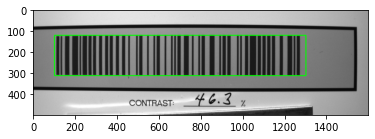

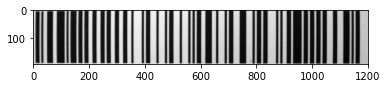

In [174]:
bound_box(f'../images/{images_paths[13]}')

[[ 165.  146.]
 [1360.  146.]
 [ 165.  336.]
 [1360.  336.]]


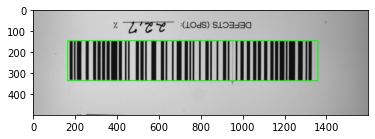

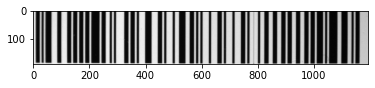

In [175]:
bound_box(f'../images/{images_paths[14]}')

[[ 180.  167.]
 [1393.  156.]
 [ 182.  361.]
 [1394.  350.]]


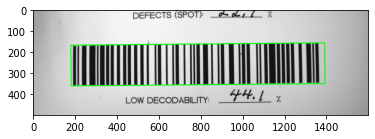

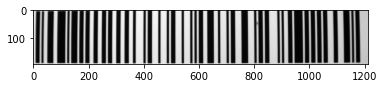

In [176]:
bound_box(f'../images/{images_paths[15]}')

[[ 203.  141.]
 [1400.  141.]
 [ 203.  332.]
 [1400.  332.]]


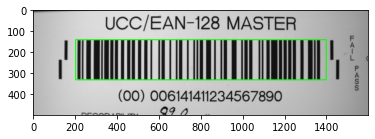

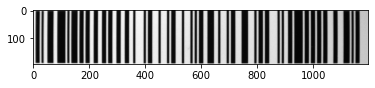

In [177]:
bound_box(f'../images/{images_paths[16]}')

[[ 195.  146.]
 [1360.  131.]
 [ 198.  383.]
 [1364.  368.]]


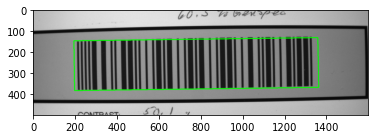

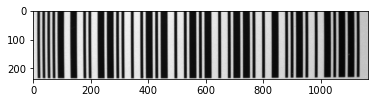

In [178]:
bound_box(f'../images/{images_paths[17]}')

[[ 196.  129.]
 [1366.  118.]
 [ 198.  370.]
 [1368.  359.]]


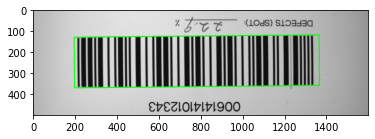

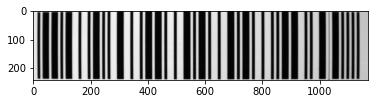

In [179]:
bound_box(f'../images/{images_paths[18]}')

[[ 229.   58.]
 [1395.   59.]
 [ 228.  297.]
 [1394.  299.]]


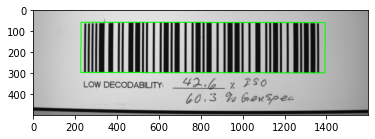

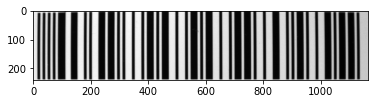

In [180]:
bound_box(f'../images/{images_paths[19]}')

[[ 247.  141.]
 [1416.  131.]
 [ 249.  382.]
 [1418.  372.]]


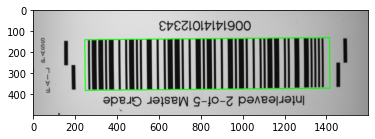

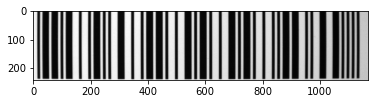

In [181]:
bound_box(f'../images/{images_paths[20]}')

In [182]:
print(f'../images/{images_paths[21]}')

images/TestChart.xls


In [183]:
#bound_box(f'../images/{images_paths[21]}')

[[194. 225.]
 [887. 225.]
 [194. 642.]
 [887. 642.]]


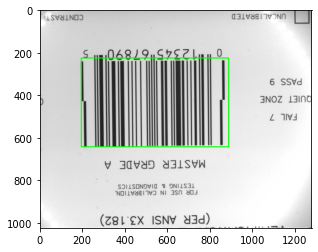

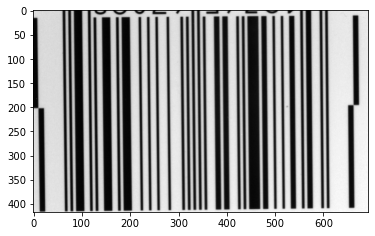

In [184]:
bound_box(f'../images/{images_paths[22]}')

[[309. 320.]
 [905. 326.]
 [306. 735.]
 [901. 741.]]


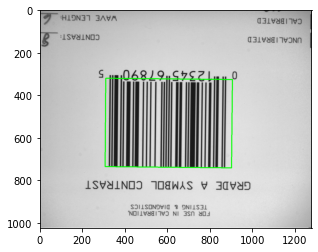

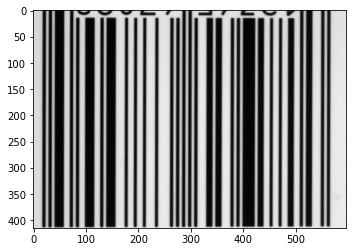

In [185]:
bound_box(f'../images/{images_paths[23]}')

[[343. 315.]
 [936. 325.]
 [335. 731.]
 [929. 742.]]


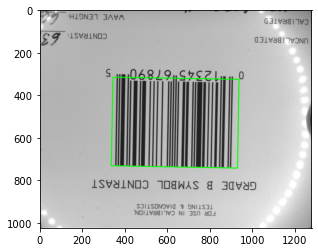

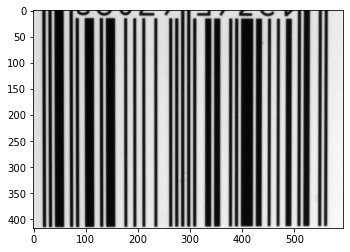

In [186]:
bound_box(f'../images/{images_paths[24]}')

[[350. 318.]
 [944. 320.]
 [348. 734.]
 [943. 737.]]


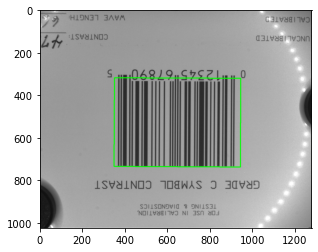

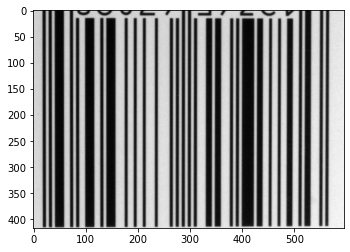

In [187]:
bound_box(f'../images/{images_paths[25]}')

[[290. 307.]
 [883. 328.]
 [275. 711.]
 [868. 732.]]


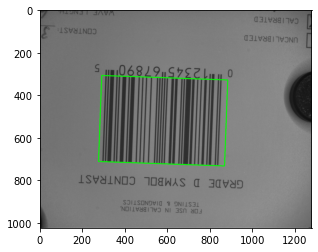

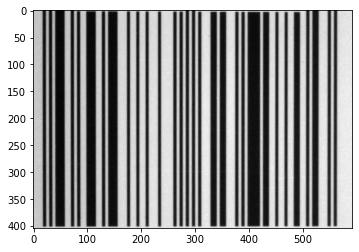

In [188]:
bound_box(f'../images/{images_paths[26]}')

[[326. 305.]
 [920. 314.]
 [320. 722.]
 [914. 731.]]


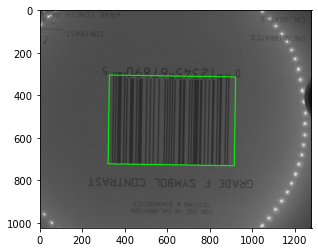

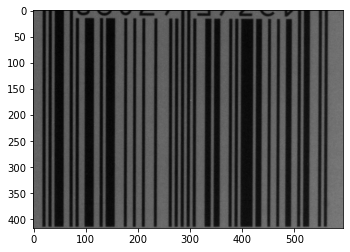

In [189]:
bound_box(f'../images/{images_paths[27]}')

[[319. 307.]
 [915. 311.]
 [317. 729.]
 [913. 733.]]


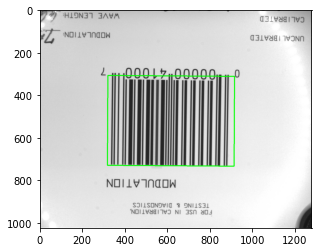

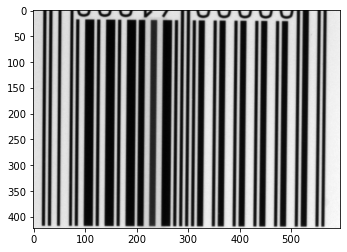

In [190]:
bound_box(f'../images/{images_paths[28]}')

[[315. 317.]
 [913. 318.]
 [315. 738.]
 [913. 738.]]


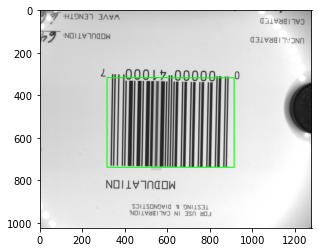

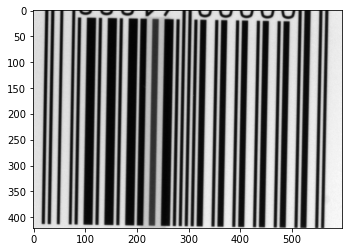

In [191]:
bound_box(f'../images/{images_paths[29]}')

[[315. 324.]
 [912. 330.]
 [311. 746.]
 [909. 751.]]


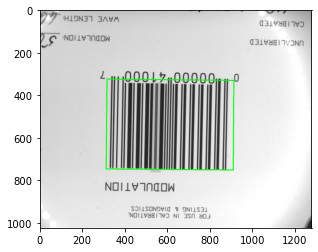

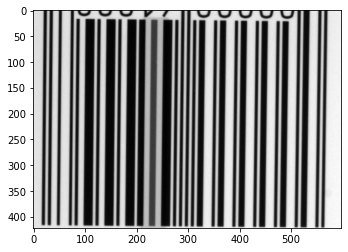

In [192]:
bound_box(f'../images/{images_paths[30]}')

[[318. 319.]
 [917. 319.]
 [318. 743.]
 [917. 743.]]


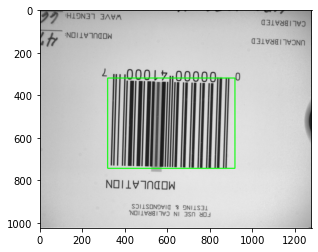

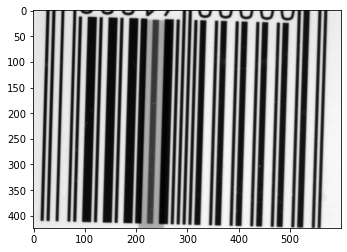

In [193]:
bound_box(f'../images/{images_paths[31]}')

[[328. 298.]
 [922. 298.]
 [328. 723.]
 [922. 723.]]


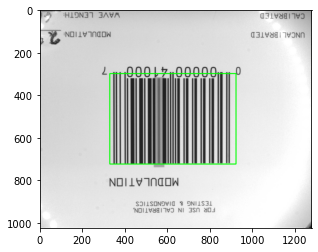

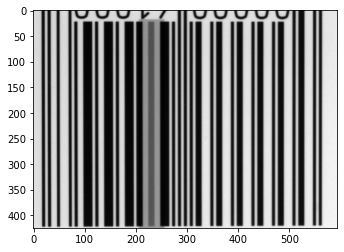

In [194]:
bound_box(f'../images/{images_paths[32]}')

[[336. 312.]
 [932. 313.]
 [336. 732.]
 [932. 732.]]


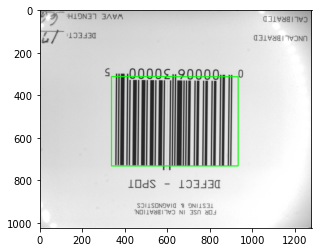

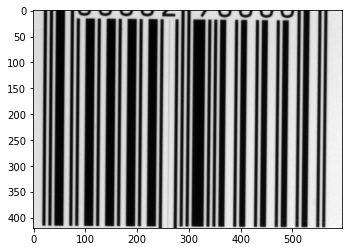

In [195]:
bound_box(f'../images/{images_paths[34]}')

[[335. 304.]
 [932. 304.]
 [335. 723.]
 [932. 723.]]


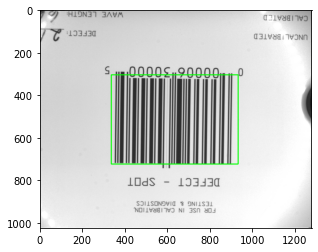

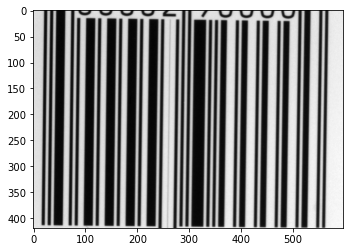

In [196]:
bound_box(f'../images/{images_paths[35]}')

[[326. 300.]
 [919. 301.]
 [326. 723.]
 [919. 723.]]


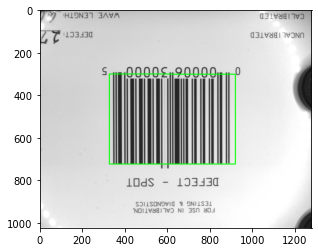

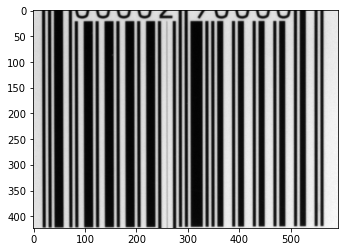

In [197]:
bound_box(f'../images/{images_paths[36]}')

[[314. 308.]
 [908. 308.]
 [314. 731.]
 [908. 731.]]


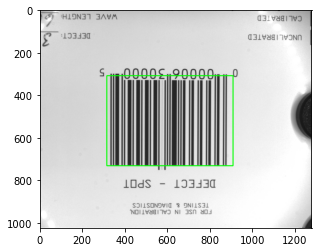

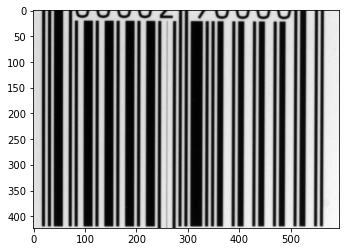

In [198]:
bound_box(f'../images/{images_paths[37]}')

[[325. 310.]
 [921. 310.]
 [325. 732.]
 [921. 732.]]


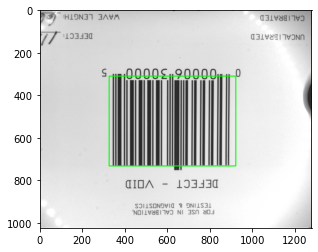

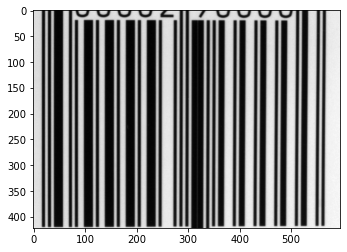

In [199]:
bound_box(f'../images/{images_paths[38]}')

[[327. 307.]
 [923. 307.]
 [327. 728.]
 [923. 728.]]


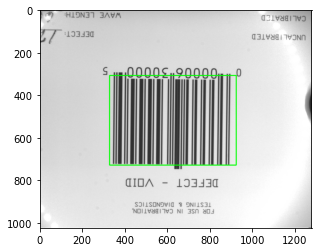

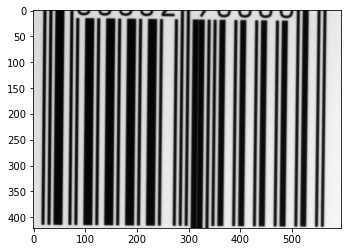

In [200]:
bound_box(f'../images/{images_paths[39]}')

[[292. 314.]
 [887. 315.]
 [292. 734.]
 [887. 734.]]


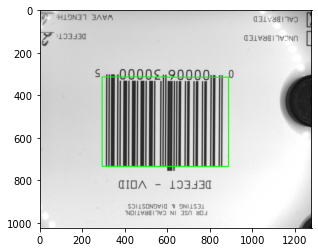

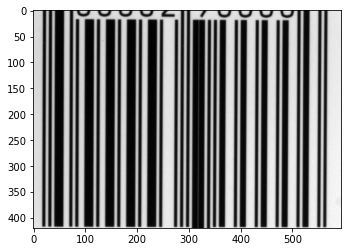

In [201]:
bound_box(f'../images/{images_paths[40]}')

[[282. 303.]
 [878. 298.]
 [286. 727.]
 [882. 722.]]


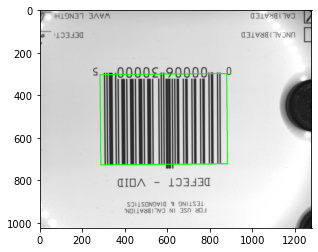

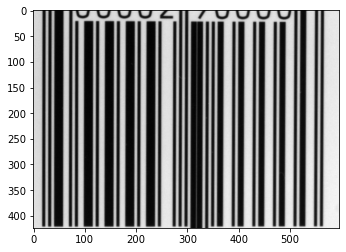

In [202]:
bound_box(f'../images/{images_paths[41]}')

[[281. 301.]
 [876. 301.]
 [281. 723.]
 [876. 723.]]


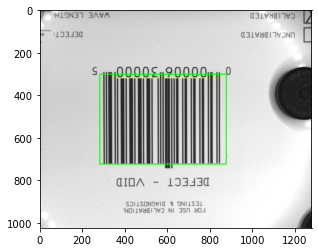

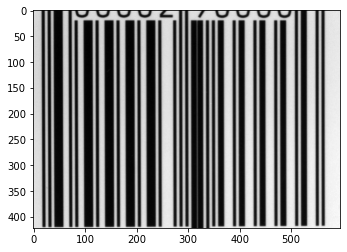

In [203]:
bound_box(f'../images/{images_paths[42]}')

[[275. 297.]
 [870. 297.]
 [275. 719.]
 [870. 719.]]


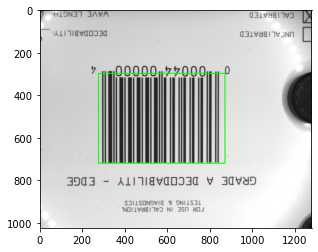

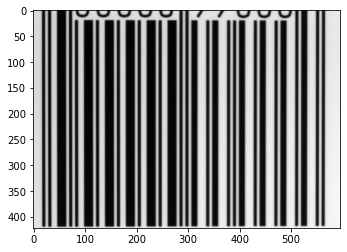

In [204]:
bound_box(f'../images/{images_paths[43]}')

[[284. 307.]
 [880. 307.]
 [284. 727.]
 [880. 727.]]


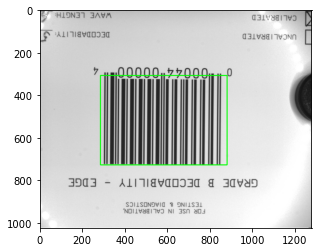

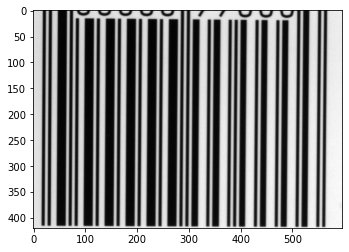

In [205]:
bound_box(f'../images/{images_paths[44]}')

[[273. 319.]
 [869. 319.]
 [273. 738.]
 [869. 738.]]


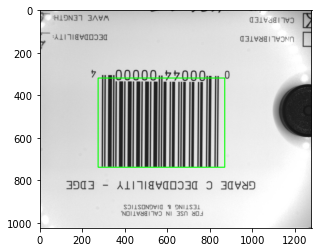

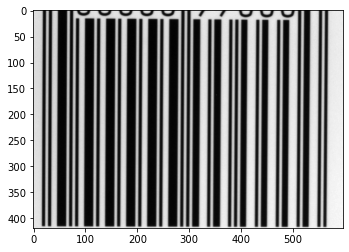

In [206]:
bound_box(f'../images/{images_paths[45]}')

[[255. 308.]
 [853. 308.]
 [255. 730.]
 [853. 730.]]


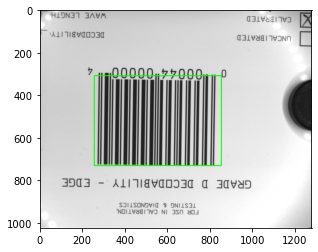

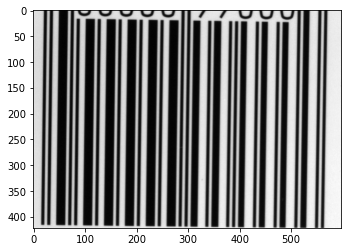

In [207]:
bound_box(f'../images/{images_paths[46]}')

[[251. 317.]
 [848. 317.]
 [251. 737.]
 [848. 737.]]


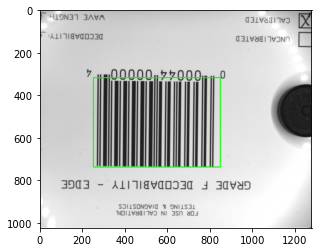

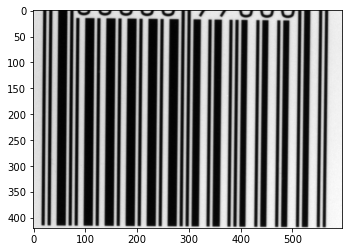

In [208]:
bound_box(f'../images/{images_paths[47]}')

[[244. 318.]
 [842. 318.]
 [244. 738.]
 [842. 738.]]


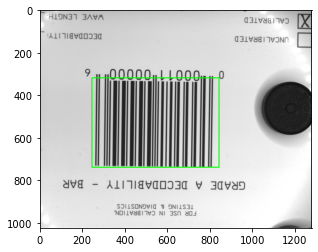

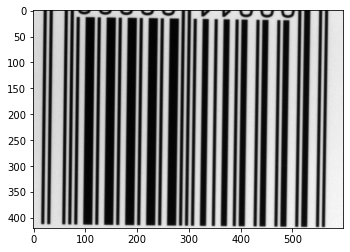

In [209]:
bound_box(f'../images/{images_paths[48]}')

[[248. 316.]
 [846. 316.]
 [248. 739.]
 [846. 739.]]


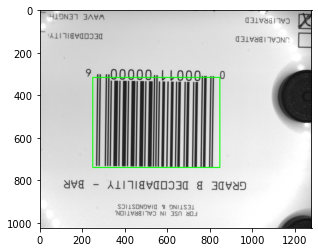

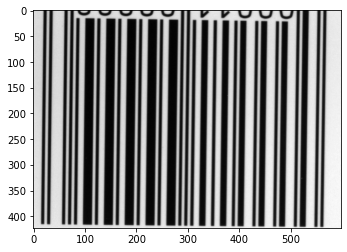

In [210]:
bound_box(f'../images/{images_paths[49]}')

[[272. 294.]
 [870. 294.]
 [272. 716.]
 [870. 716.]]


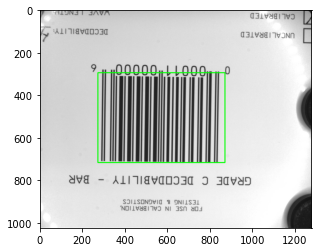

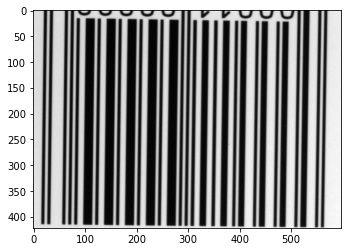

In [211]:
bound_box(f'../images/{images_paths[50]}')

[[274. 307.]
 [872. 307.]
 [274. 727.]
 [872. 727.]]


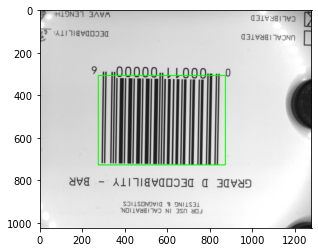

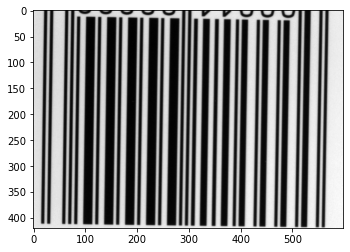

In [212]:
bound_box(f'../images/{images_paths[51]}')

[[290. 301.]
 [885. 302.]
 [290. 723.]
 [885. 723.]]


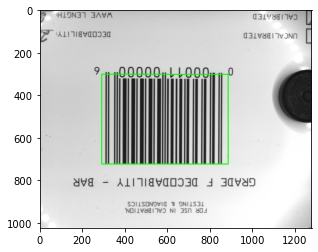

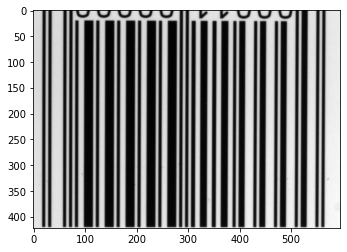

In [213]:
bound_box(f'../images/{images_paths[52]}')

[[ 87.  43.]
 [269.  43.]
 [ 87. 146.]
 [269. 146.]]
Wall time: 93.5 ms


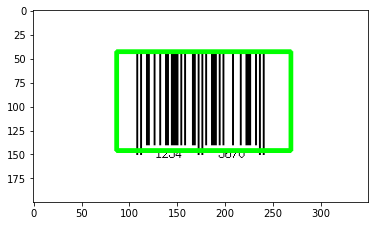

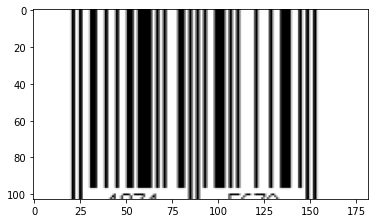

In [214]:
%%time
bound_box('other images/1.png')